In [ ]:
import importlib
import scripts.project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scripts.general_utils import utils
from scripts.general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
import pandas as pd
import numpy as np

utils.default_plot_format()
utils.pd_display_settings(3)

In [109]:
import matplotlib as mpl
import plotly.express as px
palette = px.colors.qualitative.Plotly
palette, _ = px.colors.convert_colors_to_same_type(palette, colortype='tuple')
palette = [mpl.colors.rgb2hex(color) for color in palette]
px.defaults.color_discrete_sequence = palette
sns.set_palette(sns.color_palette(palette))
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
sns.set_context("notebook", rc={"axes.labelweight": "bold"})
mpl.rcParams['scatter.marker'] = 'o'
mpl.rcParams['lines.markersize'] = 20

In [110]:
#data_path = r'processed_data\5min_nabian_2025_03_03.pkl'
data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"
#data_path = "processed_data/manual_10min_2025_03_03.pkl"
#data_path = r'processed_data\raw_metrics\optimized_20min_Nabian.pkl'
title_addon = " (10 min segments)"

In [111]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
3250,22212,22812,30.89,24.63,3.13,79.80,2.35e-08,0,1.61e-05,4.24e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3251,21611,22211,40.47,34.10,13.03,77.50,1.07e-08,0,9.96e-06,2.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3252,21010,21610,38.71,41.98,27.34,75.71,1.28e-09,0.00167,1.49e-06,3.11e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3253,34218,34818,88.51,31.71,12.61,79.37,1.33e-08,0.00167,1.59e-05,3.19e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3254,76304,76903,173.75,220.18,22.22,74.74,3.17e-09,0.00167,3.57e-06,1.2e-06,...,10.23,0.43,1,0,0,True,0,0,1,DPN


In [112]:
medians = deciles.produce_median_melt(data, indicator_columns)
medians

,id,DPN,metric,value
0,0,False,SDRR,79.23
1,3,False,SDRR,63.16
2,4,False,SDRR,78.74
3,5,False,SDRR,58.39
4,7,False,SDRR,67.28
...,...,...,...,...
515,35,False,D2,-1.50
516,37,True,D2,-5.81
517,38,True,D2,-2.16
518,39,True,D2,-3.26


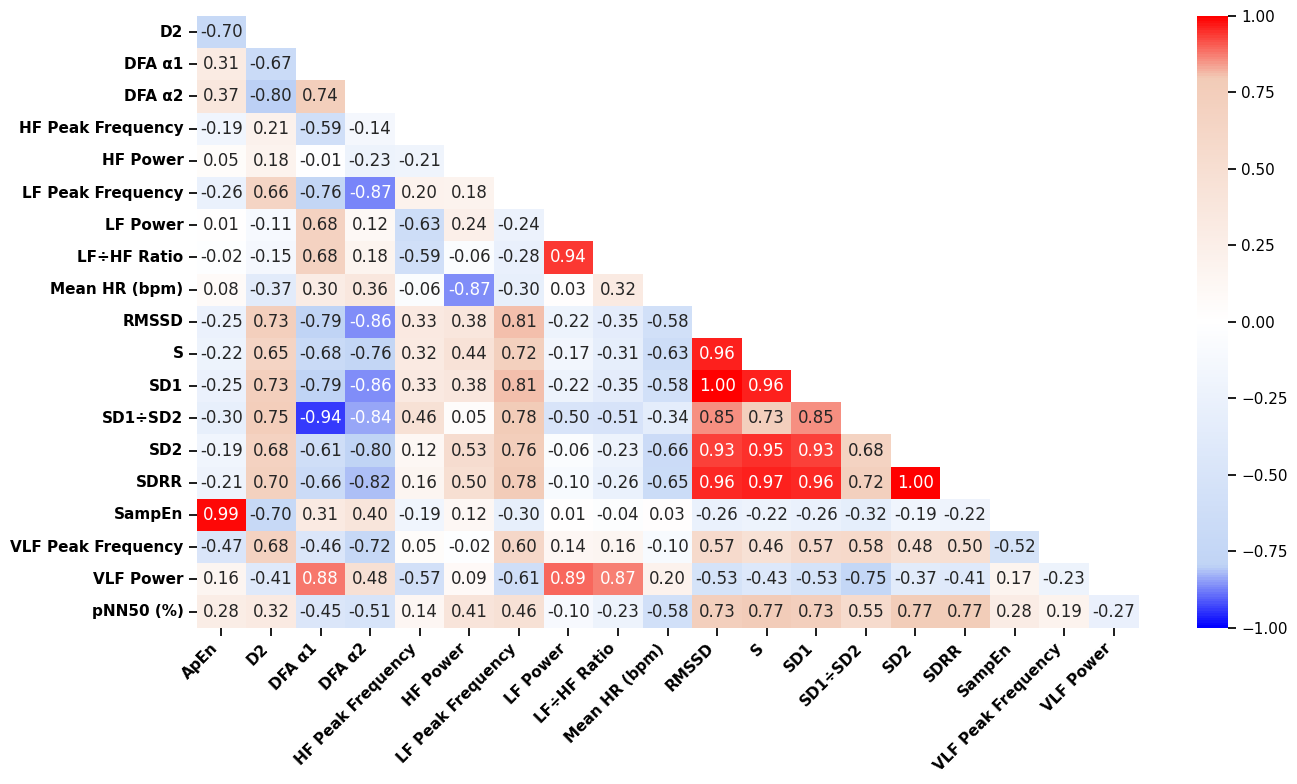

In [113]:
from matplotlib.colors import LinearSegmentedColormap

correlation_matrix = medians.pivot(index='id', columns='metric', values='value').corr()



mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(14, 8))

correlation_matrix = correlation_matrix.drop(index='ApEn', errors='ignore')
correlation_matrix = correlation_matrix.drop(columns='pNN50 (%)', errors='ignore')
mask = mask[1:, :-1]

nodes = [0.0, 0.1, 0.5, 0.9, 1.0]  # normalized positions for -1, -0.8, 0, 0.8, 1
colors = ['blue', '#C0D4F5', 'white', '#F2CBB7', 'red']
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))


#custom_cmap.set_bad(color='gray')  # Set color for masked areas
sns.heatmap(correlation_matrix, mask=mask, cmap=custom_cmap, vmax=1, vmin=-1, center=0, annot=True, fmt='.2f')


plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
output_path = r"results\metric_covariance.png"
plt.savefig(output_path, bbox_inches='tight', dpi=450)
plt.show()

In [114]:
# Group by 'DPN' and calculate the mean for each metric
grouped_means = medians.groupby(['DPN', 'metric'])['value'].mean().unstack()

# Transpose the DataFrame to make columns into rows
grouped_means = grouped_means.T

power_metrics = ['HF Power', 'LF Power', 'VLF Power']


# Calculate the difference (Diabetes Mean - DPN Mean)
grouped_means['Difference'] = grouped_means[False] - grouped_means[True]

# Rename columns for clarity
grouped_means.rename(columns={False: 'Diabetes Mean', True: 'DPN Mean'}, inplace=True)
grouped_means.loc[power_metrics, ['Diabetes Mean', 'DPN Mean', 'Difference']] *= 1e6


def round_to_sig_figs(x, sig_figs=2):
    if x == 0:
        return 0
    else:
        return round(x, -int(np.floor(np.log10(abs(x)))) + (sig_figs - 1))
    
    # Multiply power metrics by 1e6


grouped_means[['Diabetes Mean', 'DPN Mean']] = grouped_means[['Diabetes Mean', 'DPN Mean']].applymap(lambda x: round_to_sig_figs(x, sig_figs=3))
grouped_means['Difference'] = grouped_means['Difference'].apply(lambda x: round_to_sig_figs(x, sig_figs=2))

display(grouped_means)

DPN,Diabetes Mean,DPN Mean,Difference
metric,,,
ApEn,0.95,0.92,0.031
D2,-2.82,-3.49,0.67
DFA α1,0.92,0.97,-0.052
DFA α2,0.83,0.97,-0.14
HF Peak Frequency,0.33,0.35,-0.021
HF Power,544,366,180
LF Peak Frequency,0.12,0.10,0.014
LF Power,50.70,28.20,23
LF÷HF Ratio,0.0938,0.0844,0.0094


In [115]:
import scripts.project_utils.deciles as deciles
normalized_data = deciles.produce_median_melt(data, indicator_columns)

# Normalize values for each metric
for metric in normalized_data['metric'].unique():
    mask = normalized_data['metric'] == metric
    values = normalized_data.loc[mask, 'value']
    normalized_data.loc[mask, 'value'] = (values - values.min()) / (values.max() - values.min())

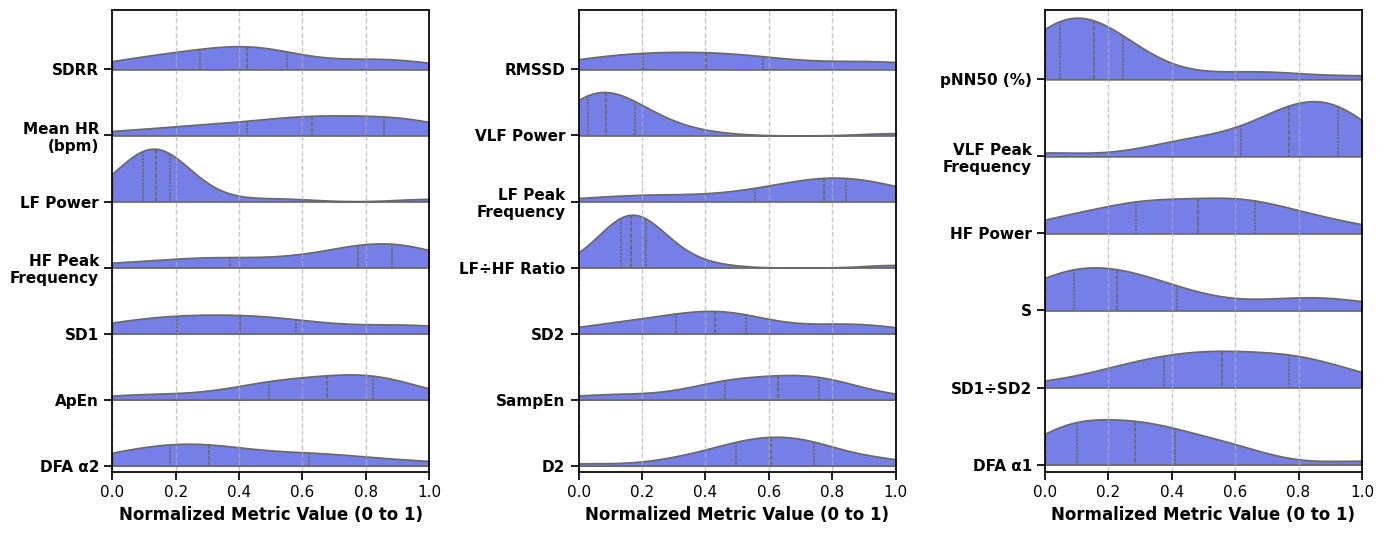

In [116]:
def wrap_labels(labels, min_length=6):
    wrapped_labels = []
    for label in labels:
        text = label.get_text()
        if len(text) > min_length:
            split_index = text.find(' ', min_length)
            if split_index != -1:
                wrapped_text = text[:split_index] + '\n' + text[split_index + 1:]
                label.set_text(wrapped_text)
        wrapped_labels.append(label)
    return wrapped_labels


def plot_violin(data, metrics, ax, title):
    sns.violinplot(
        data=data[data['metric'].isin(metrics)],
        y='metric',
        x='value',
        split=True,
        inner='quartile',
        cut=0,
        ax=ax
    )
    plt.xlim([0,1])
    ax.set_title(None)
    ax.set_xlabel('Normalized Metric Value (0 to 1)')
    ax.set_ylabel(None)
    ax.grid(axis='x', linestyle='--', alpha=0.7)


    ax.set_yticks([tick + 0.4 for tick in ax.get_yticks()])
    # Wrap labels if longer than 10 characters


    ax.set_yticklabels(wrap_labels(ax.get_yticklabels()))

    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

# Split metrics into three groups
metrics = normalized_data['metric'].unique()
grouped_metrics = [metrics[i::3] for i in range(3)]

# Create a figure with three horizontal subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 5.5), sharex=True)
# Plot each group of metrics
for ax, group, title in zip(axes, grouped_metrics, ['Group 1 Metrics', 'Group 2 Metrics', 'Group 3 Metrics']):
    plot_violin(normalized_data, group, ax, title)

# Adjust layout and show the plot
plt.tight_layout()



output_path = os.path.join("resources", "metric_distribution.png")
plt.savefig(output_path, bbox_inches='tight', dpi=450)

plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_13360\2831543517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["DPN"].replace({False: "Diabetes", True: "DPN"}, inplace=True)


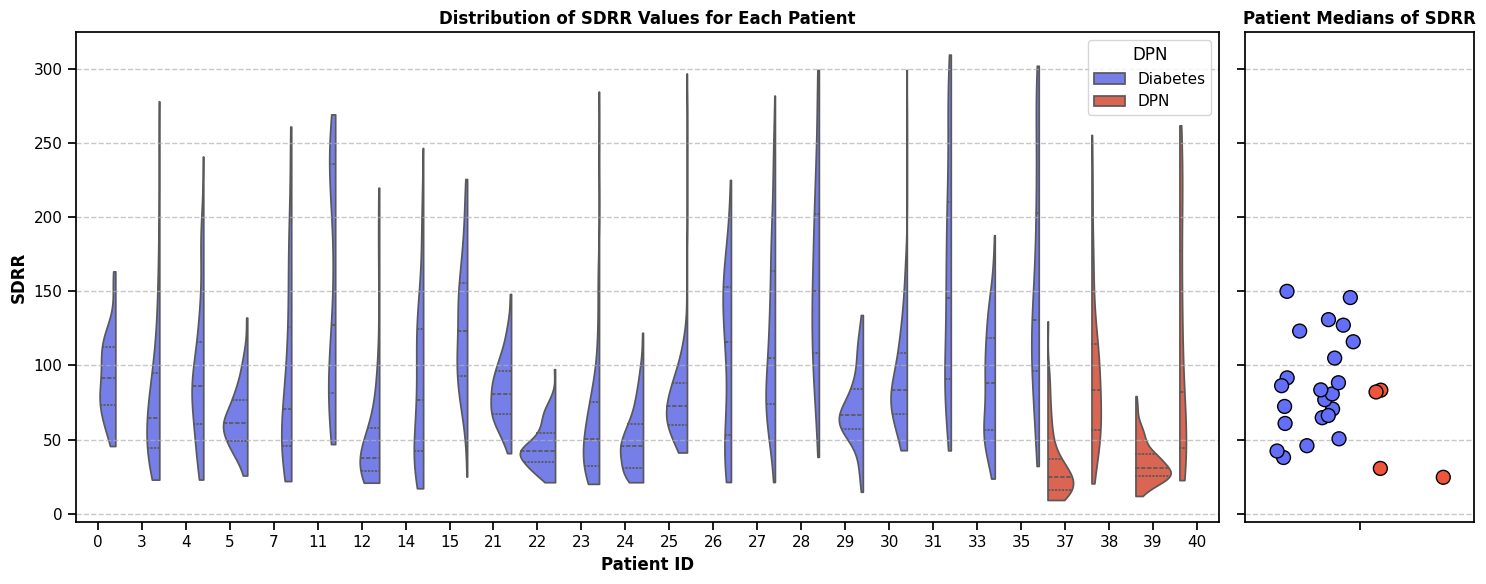

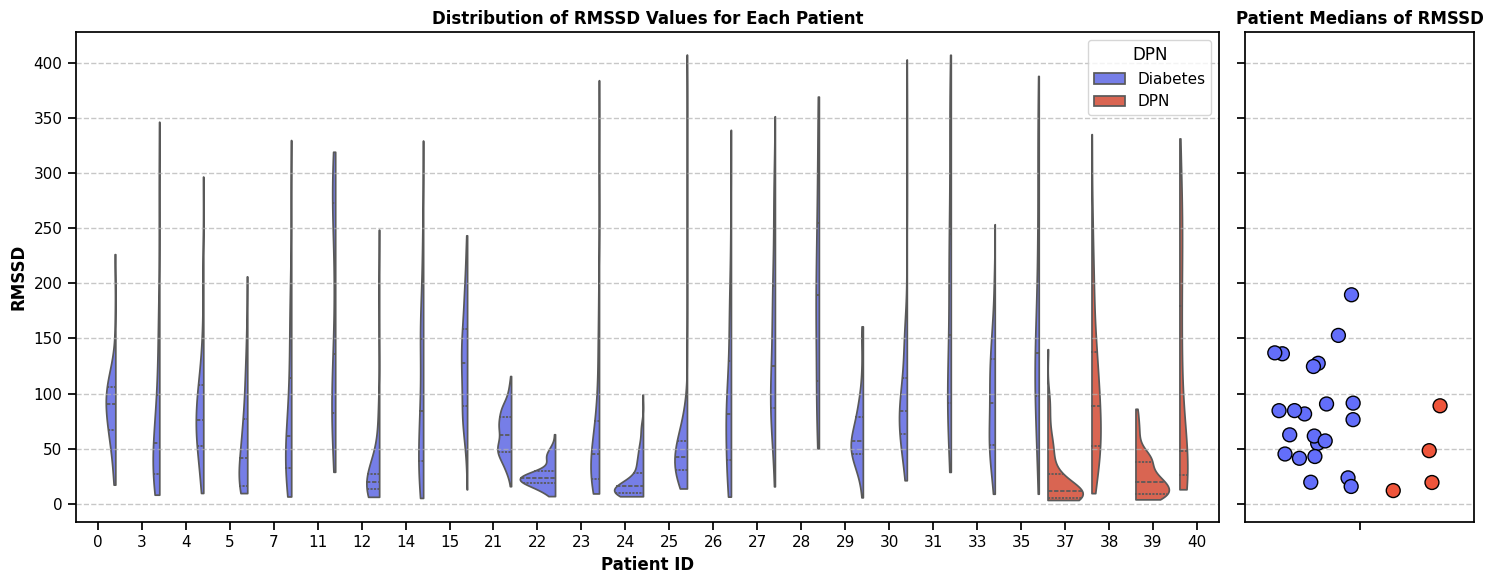

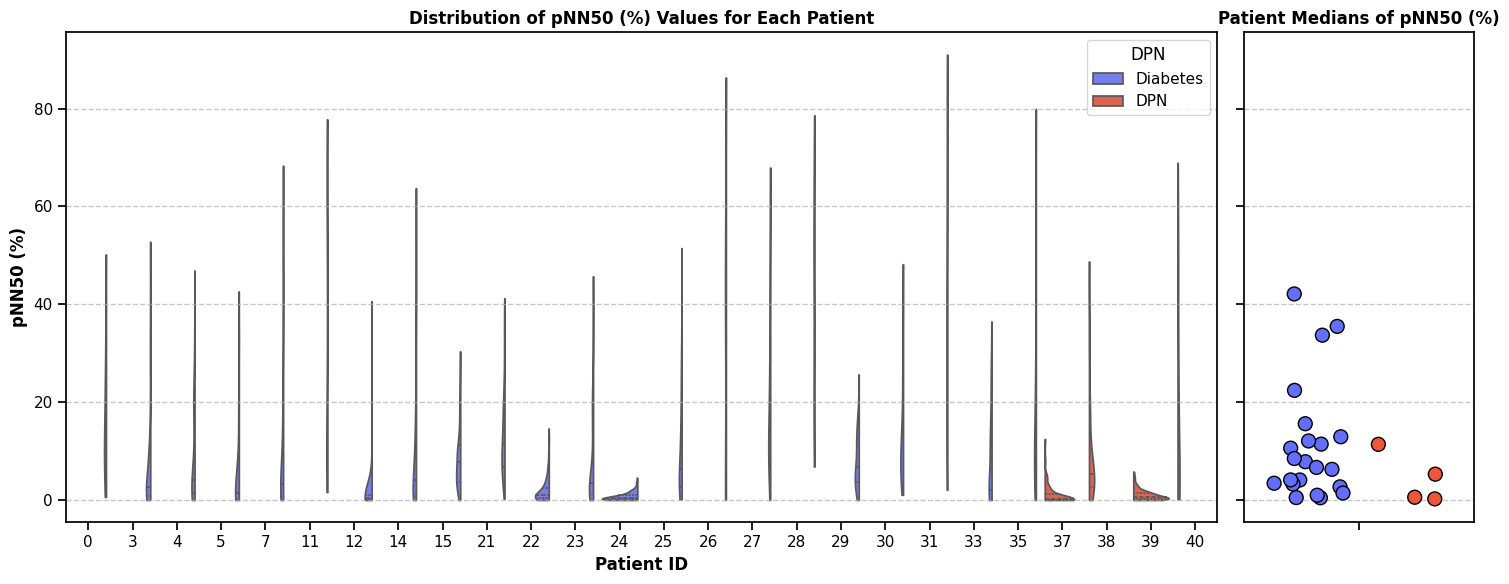

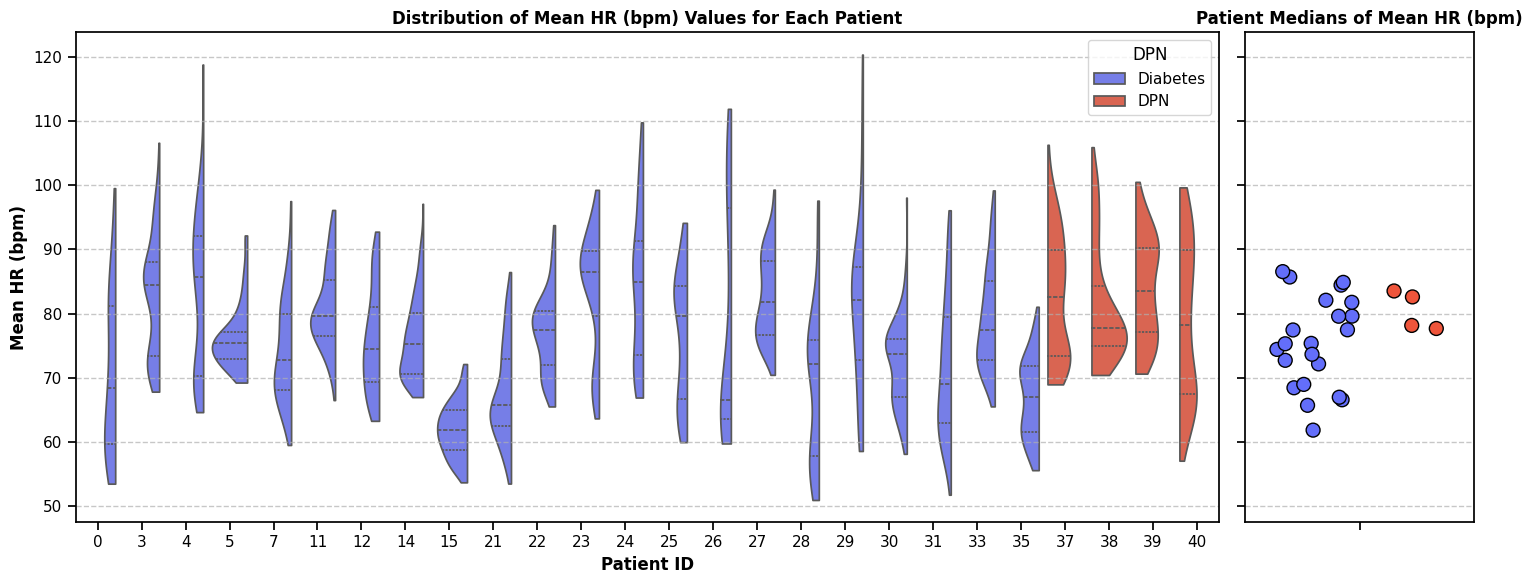

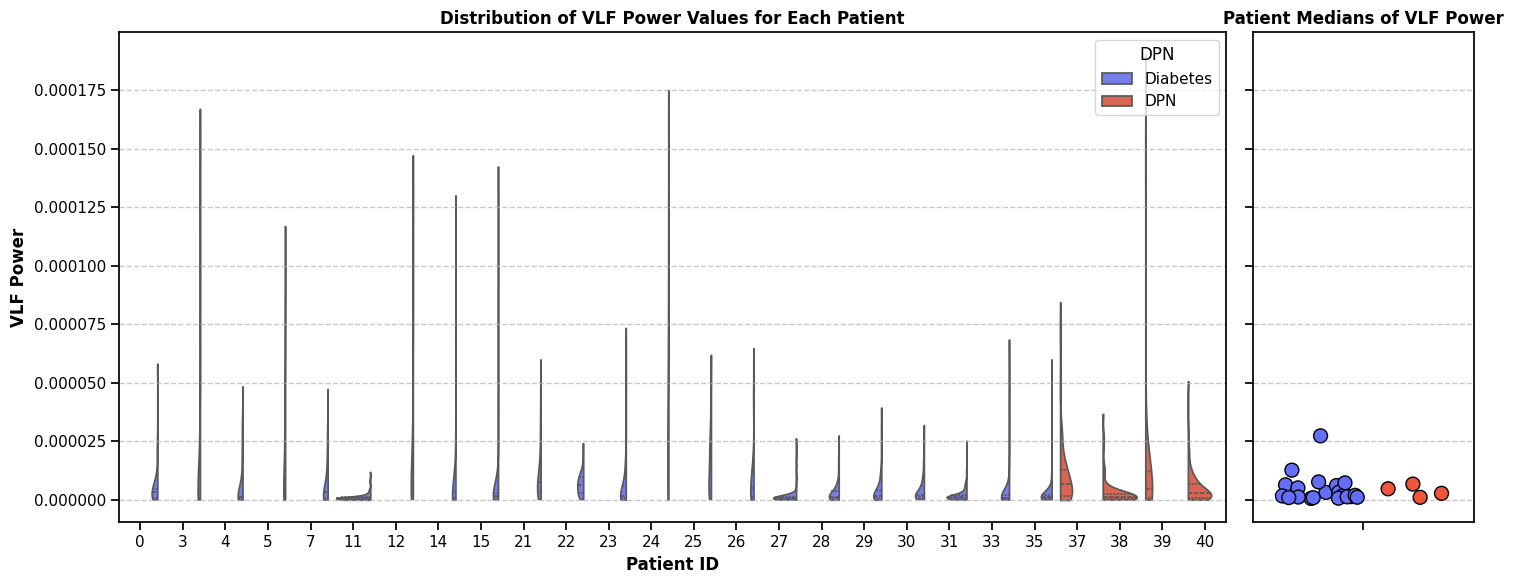

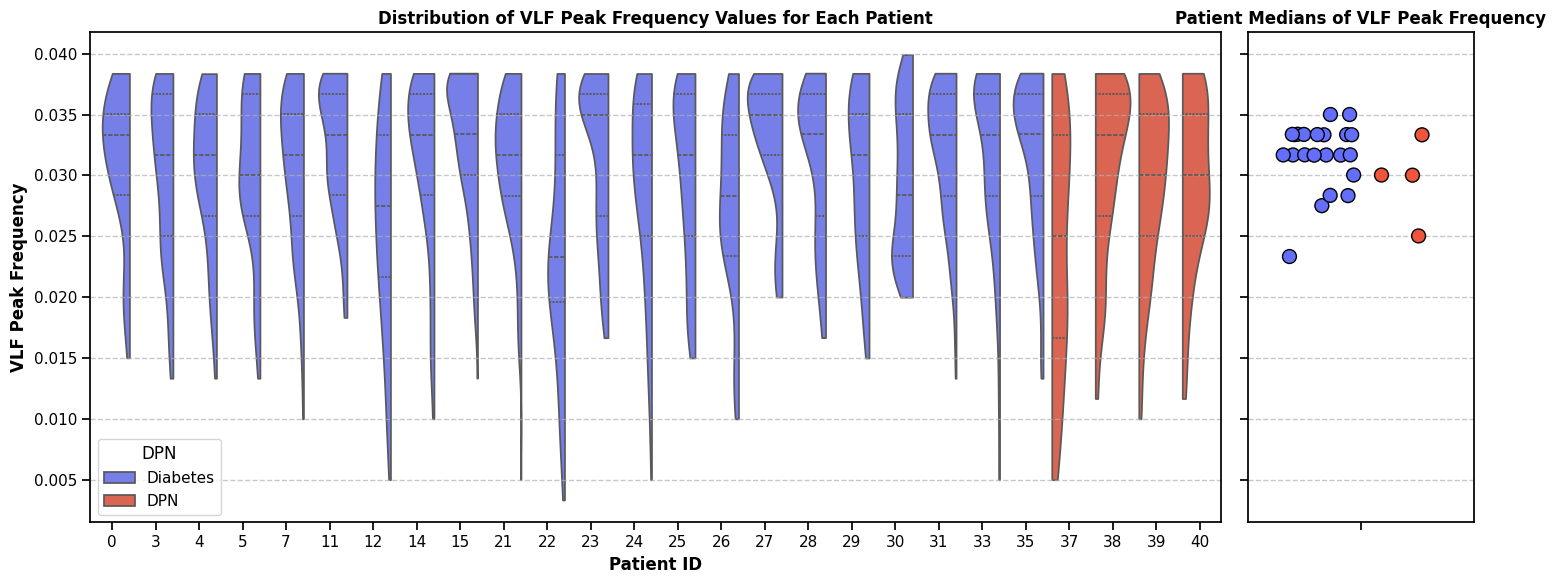

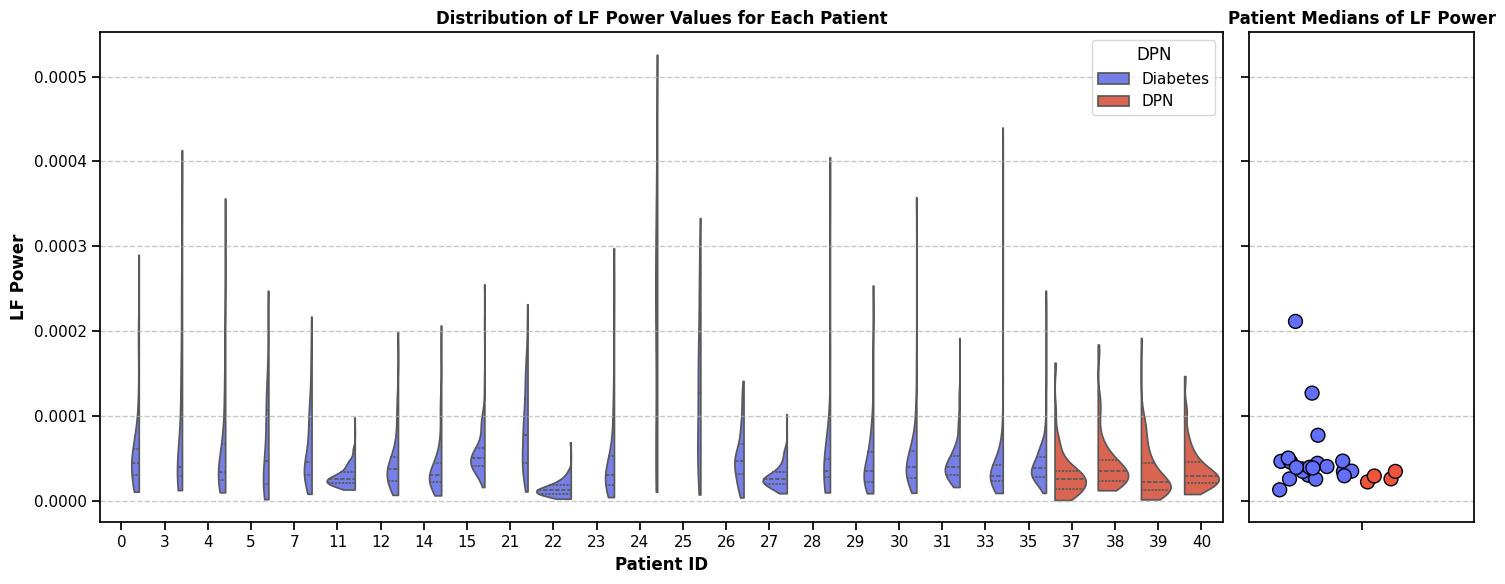

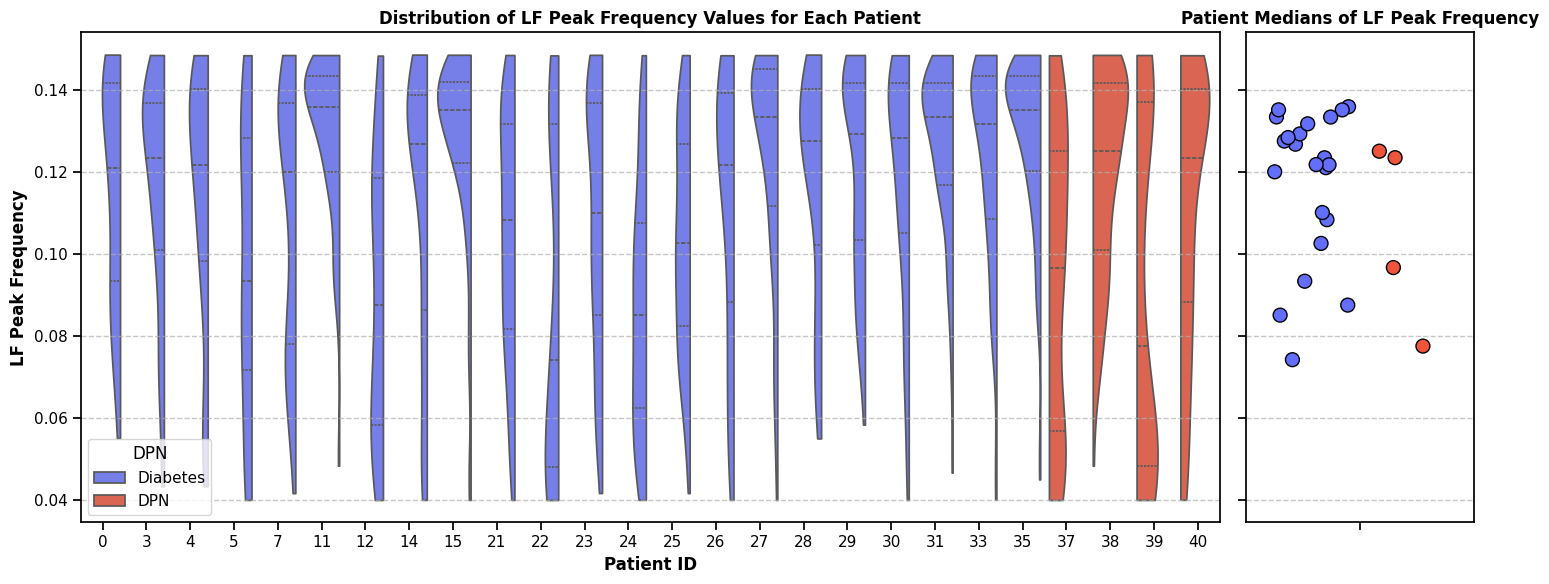

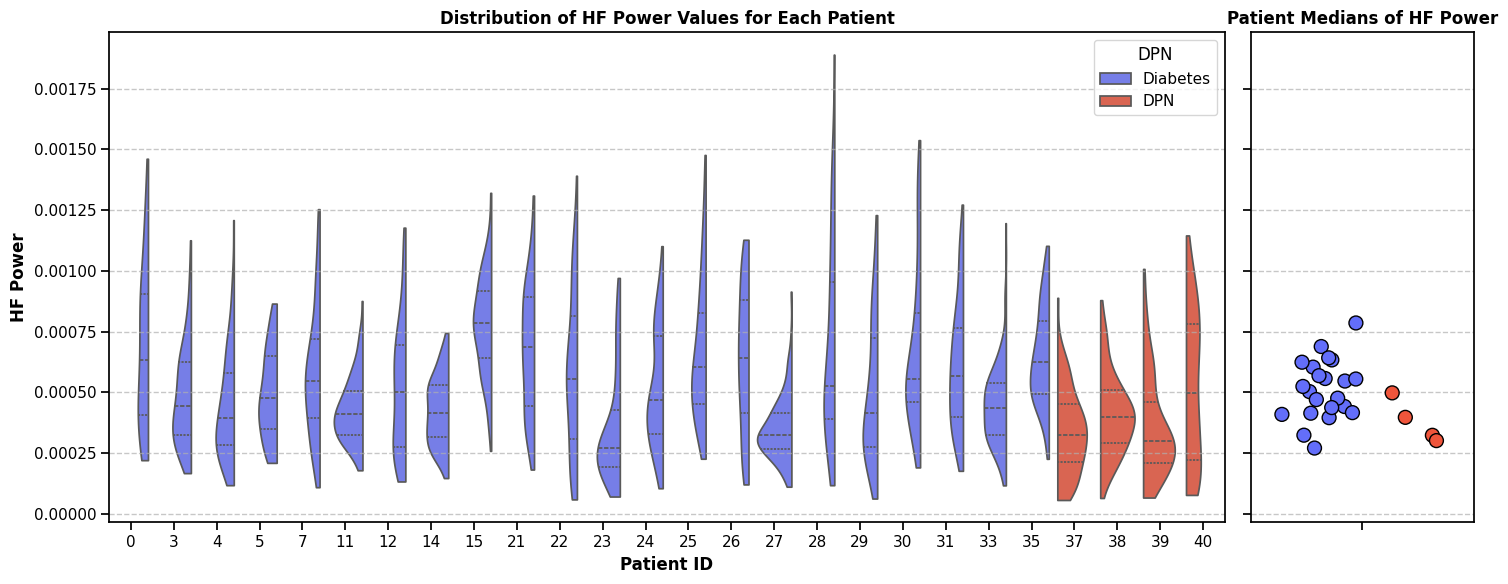

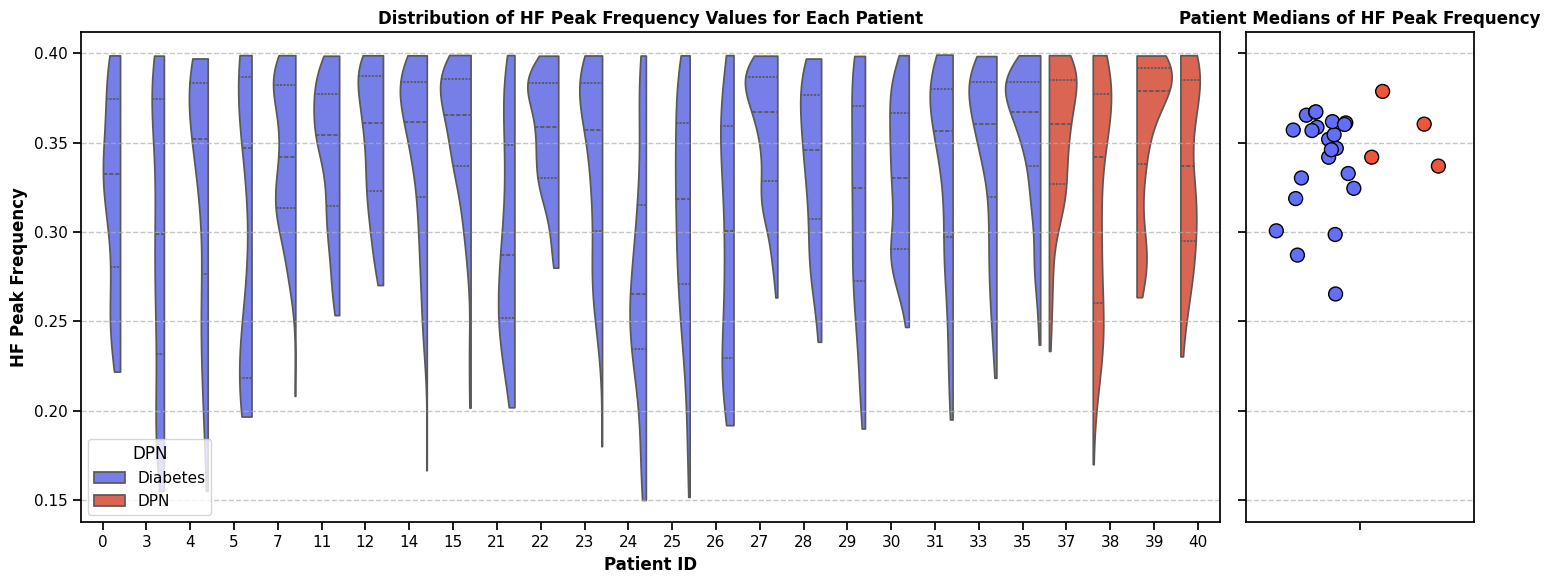

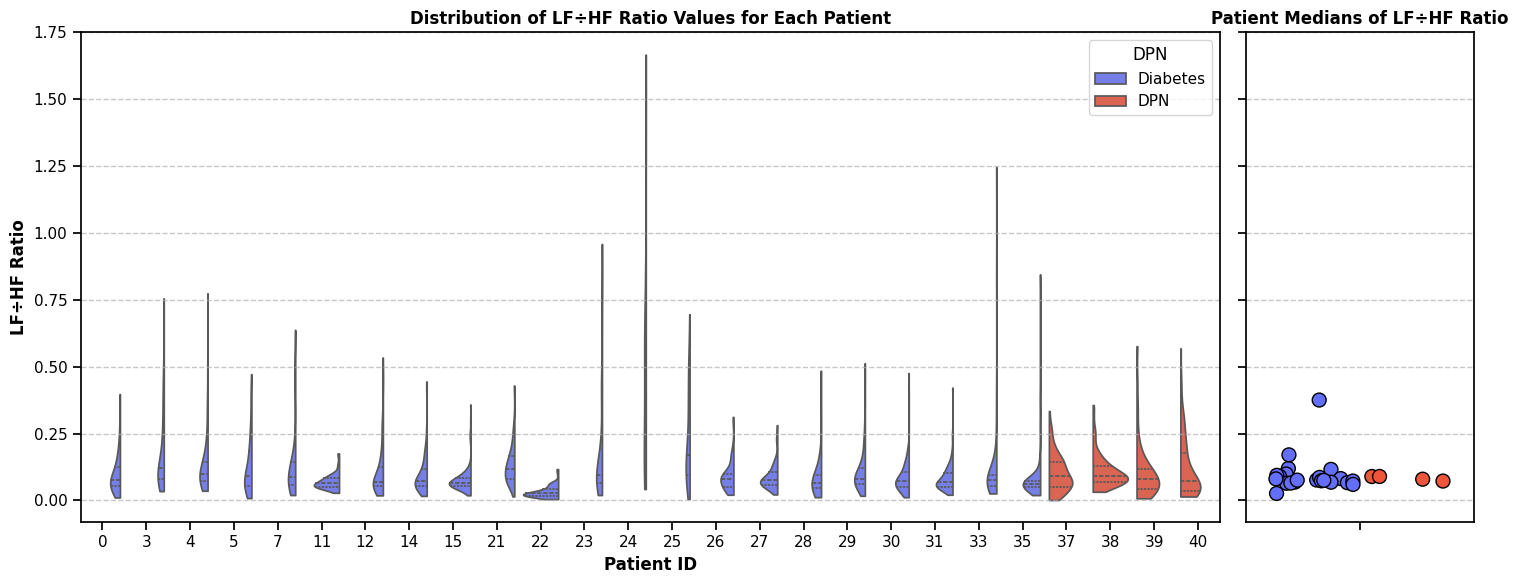

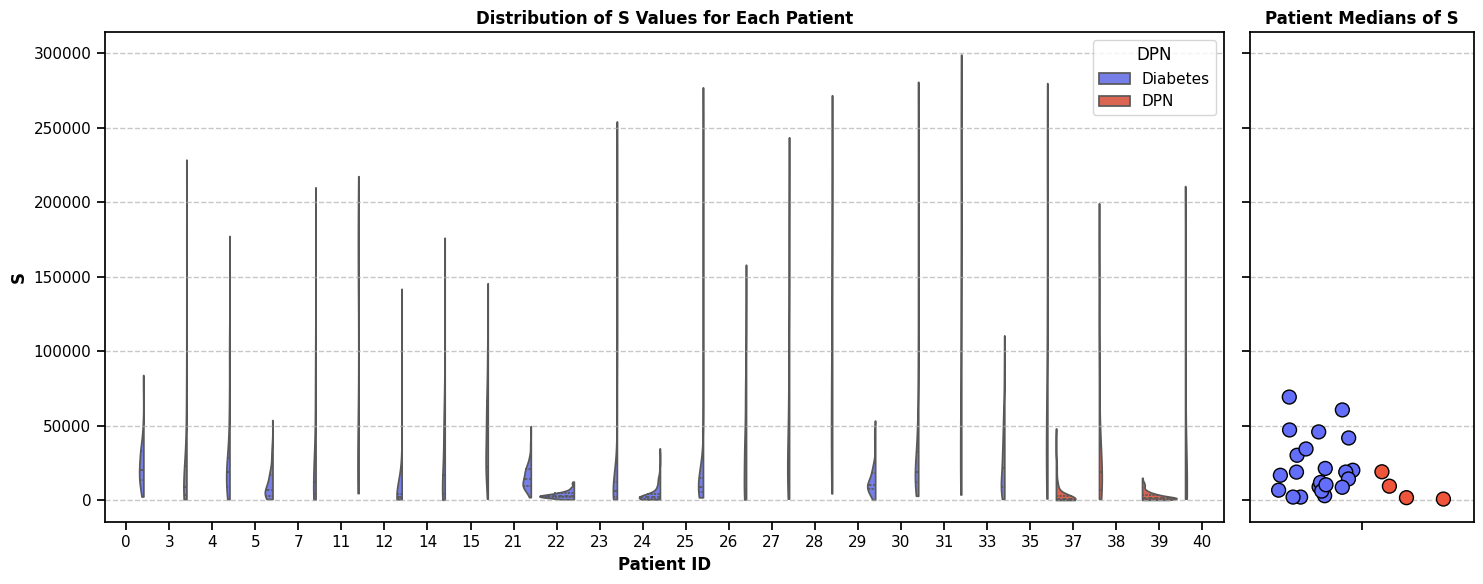

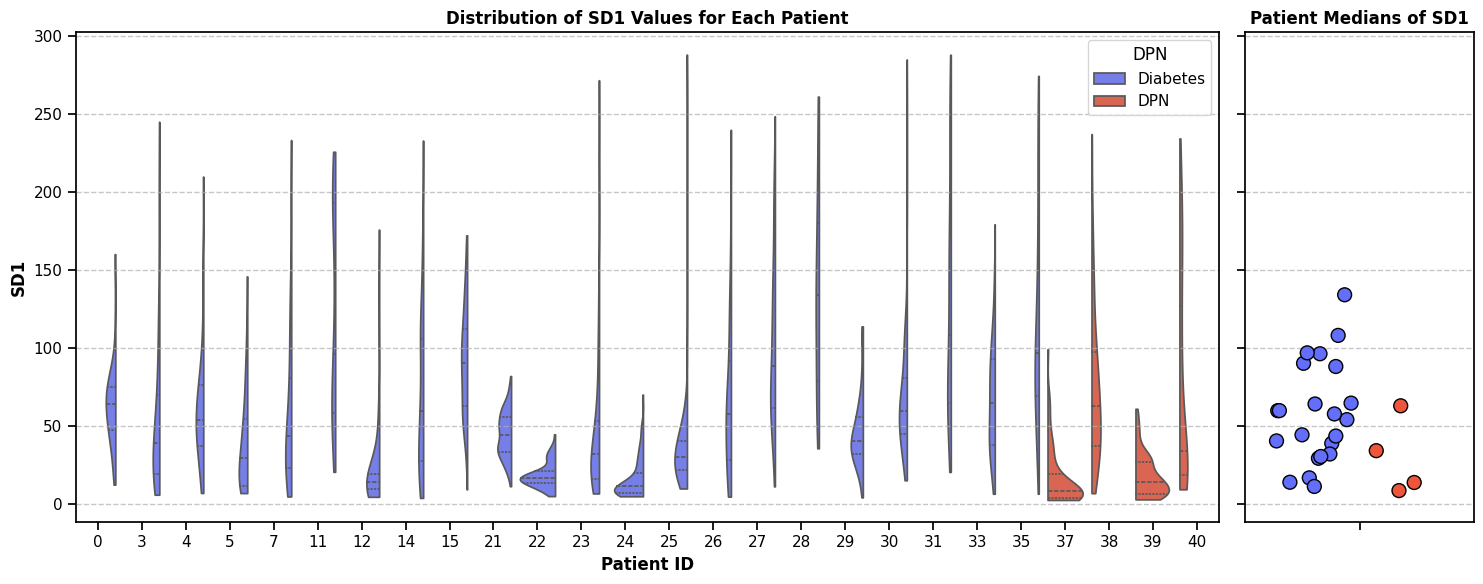

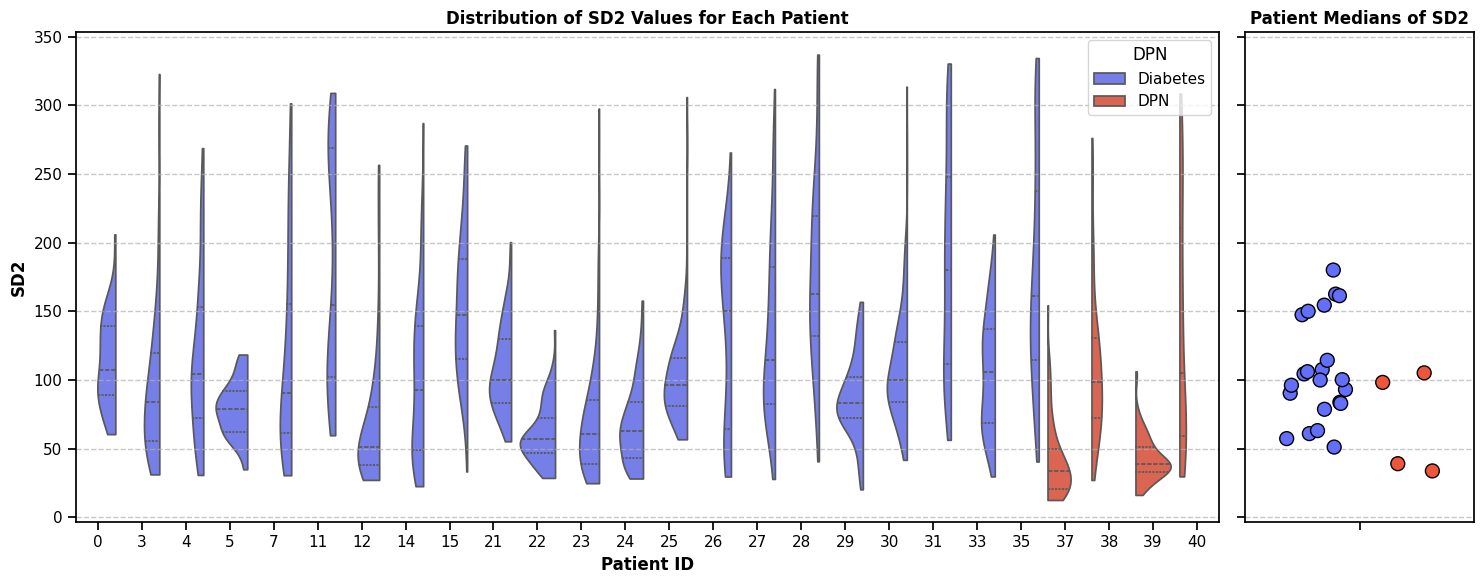

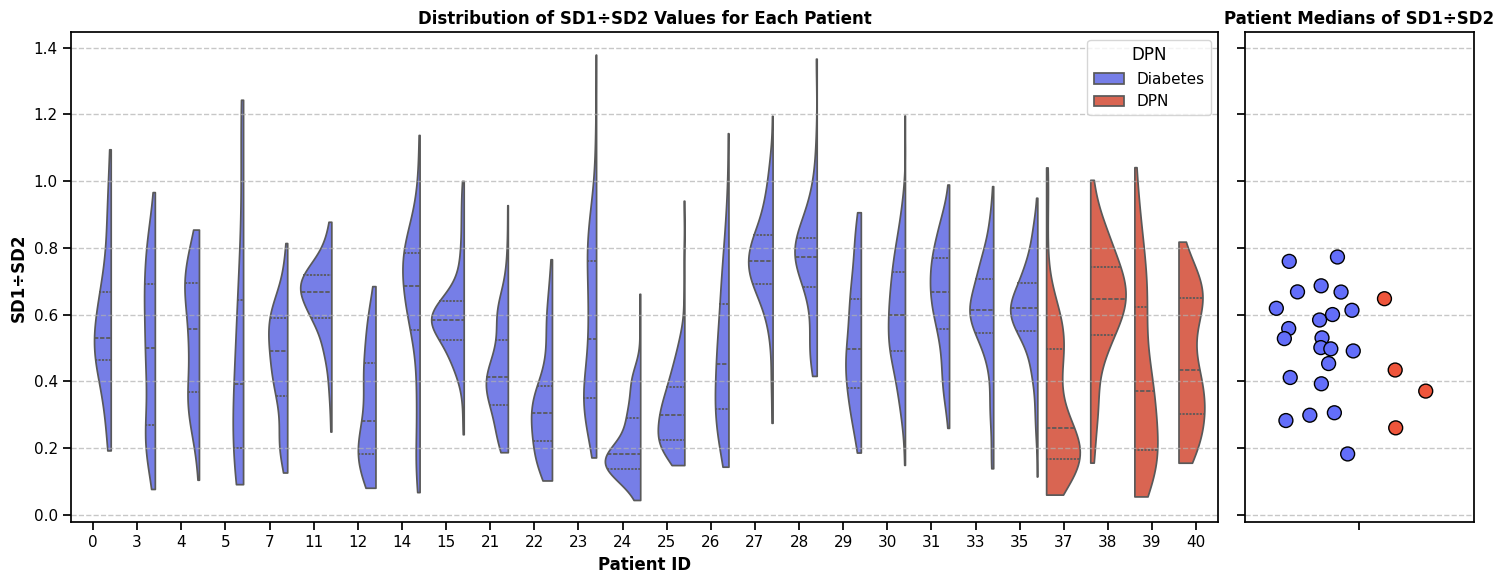

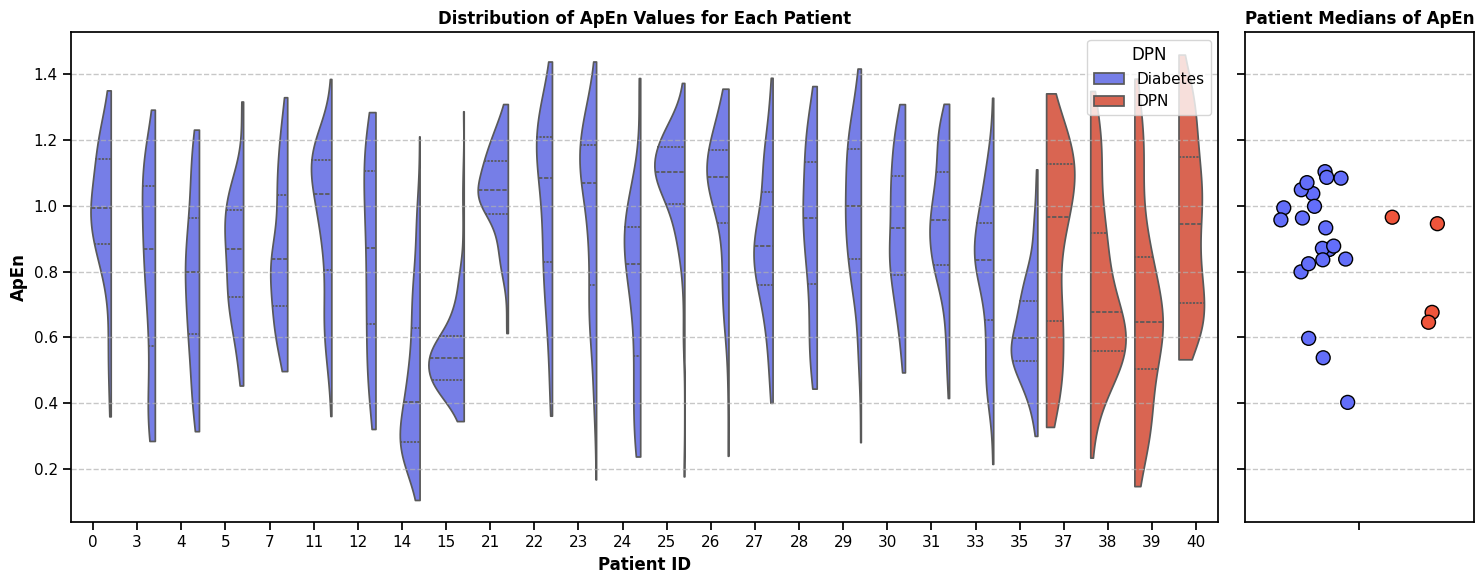

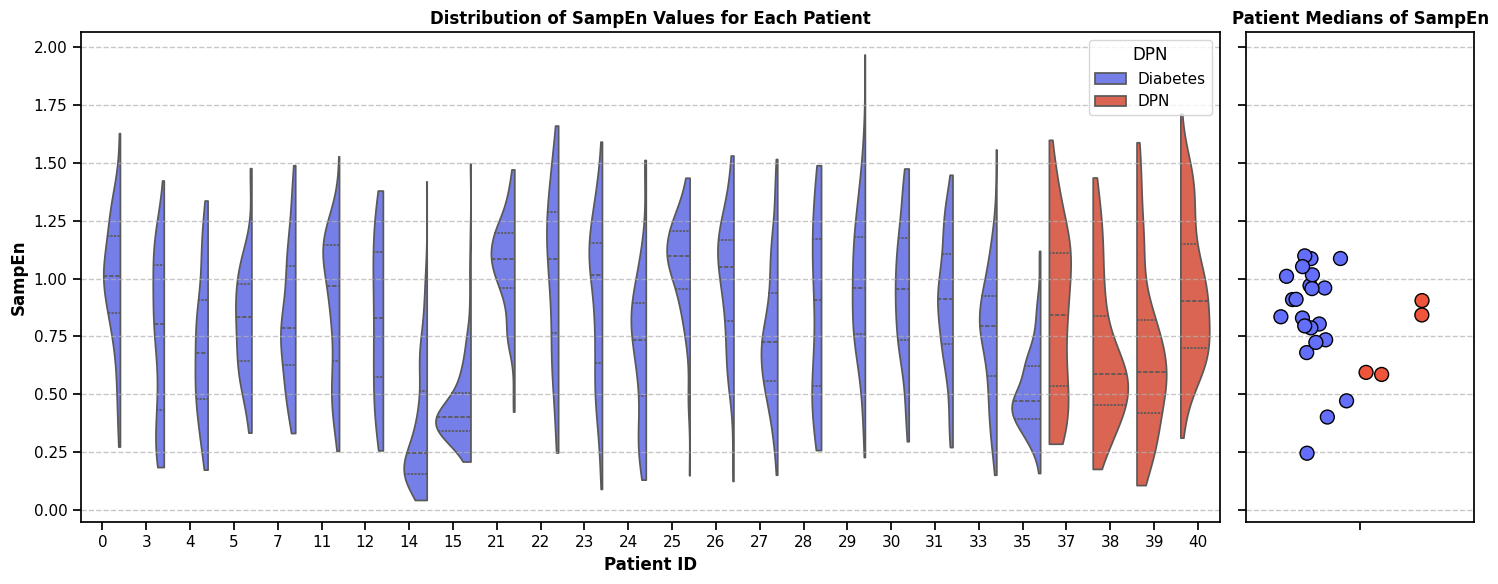

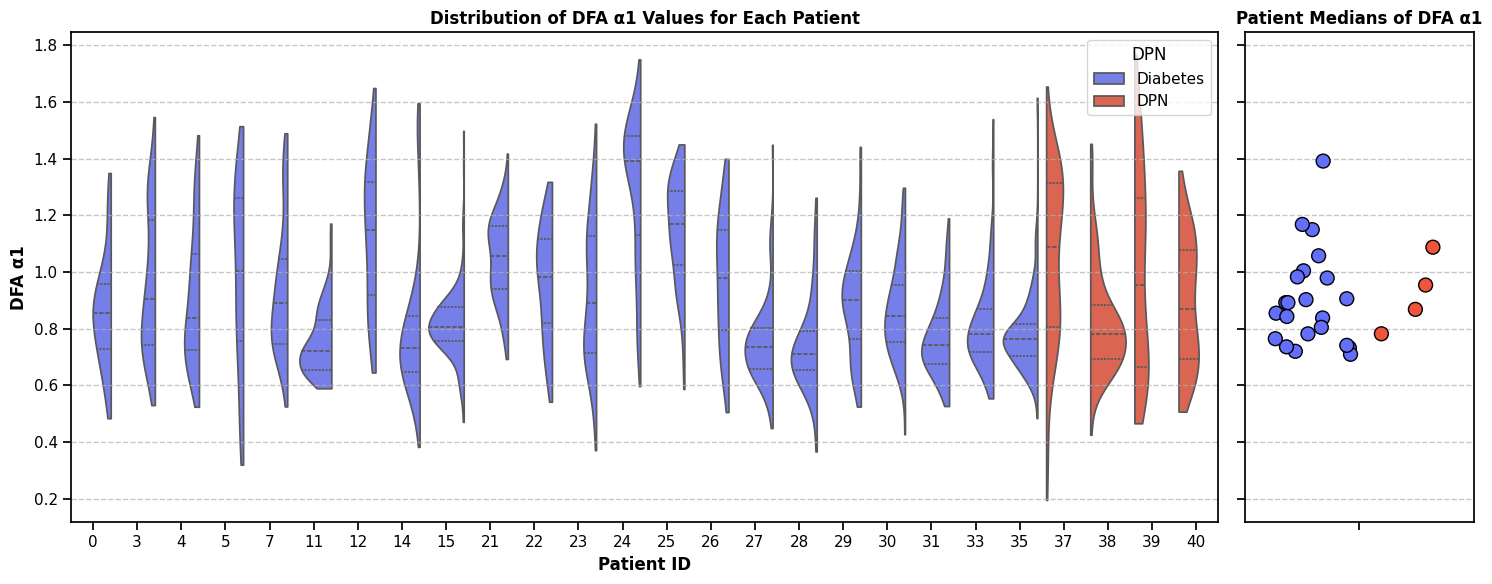

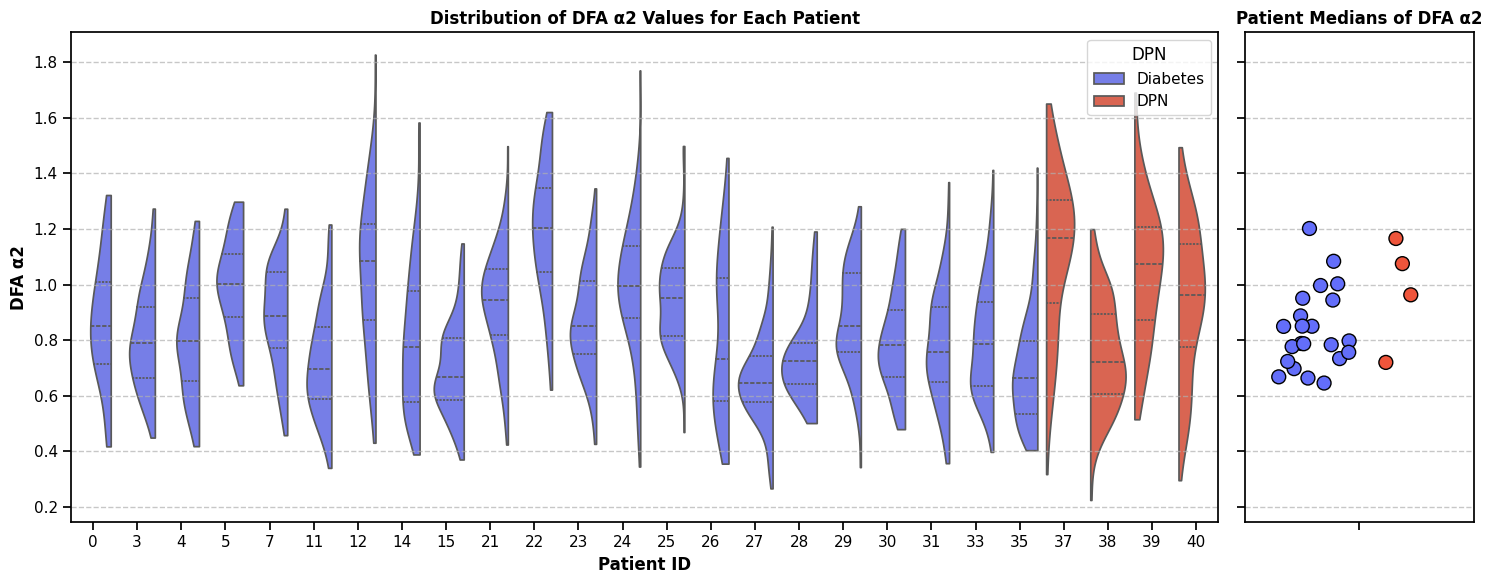

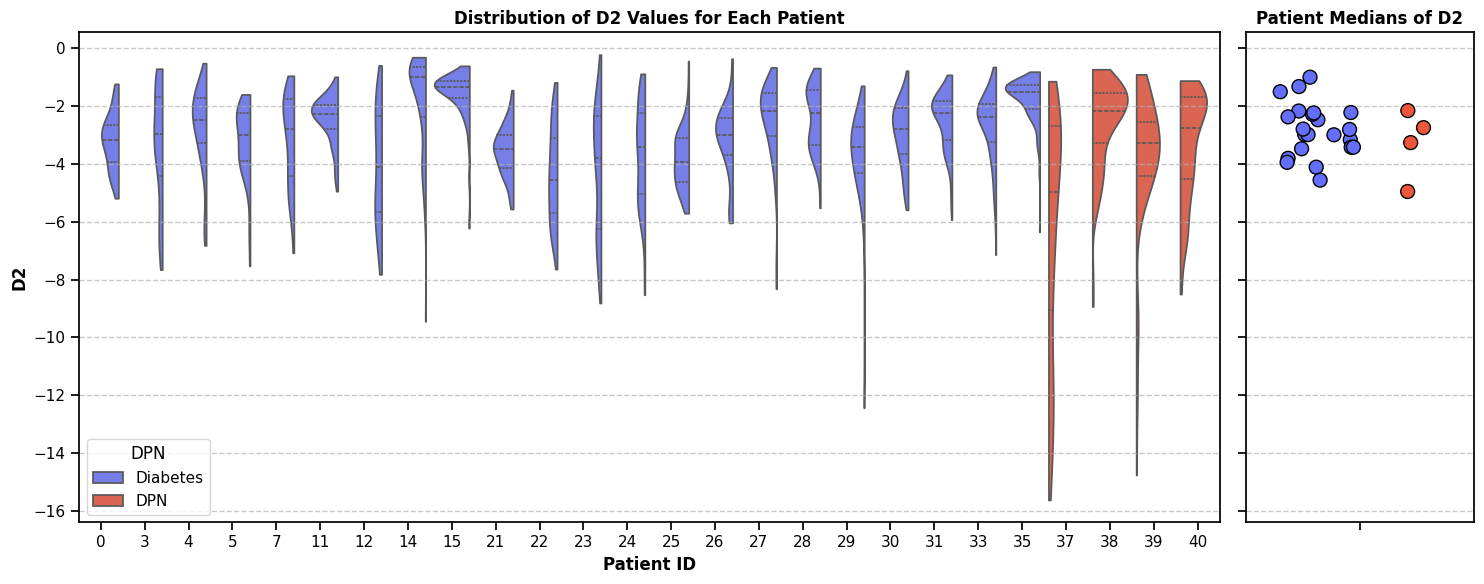

In [117]:
data = data[abs(data.D2)<16]
data["DPN"].replace({False: "Diabetes", True: "DPN"}, inplace=True)
def plot_metric_distribution(metric, data):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [5, 1]}, sharey=True)

    
    sns.violinplot(
        data=data,
        x="id",
        split=True,
        y=metric,
        hue = "DPN",
        inner='quartile',
        cut=0,
        ax=ax1,
    )
    #ax1.legend(title="Condition", labels=["Control", "DPN"])
    ax1.set_title(f"Distribution of {metric} Values for Each Patient")
    ax1.set_xlabel("Patient ID")
    ax1.set_ylabel(metric)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)



    medians = deciles.produce_median_melt(data, [metric])
    # Right subplot: Scatter plot
    sns.stripplot(
        y="value", 
        data=medians,
        size=10,
        ax=ax2,
        hue="DPN",
        dodge=True,
        edgecolor='black', linewidth=1,
        jitter=0.35,
    )
    ax2.set_title(f"Patient Medians of {metric}")
    ax2.set_ylabel(None)
   # ax2.set_ylabel(metric)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)


    ax2.legend().set_visible(False)
    plt.tight_layout()



    #plt.show()
# Example usage

for col in indicator_columns:

    plot_metric_distribution(col, data)
    metric = col.replace(" (%)", "")
    output_path = os.path.join("resources/dist_median_plots", f"{metric}_distribution_plot.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=450)
    plt.show()